In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

from smt.sampling_methods import LHS
from scipy.io import savemat

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

device = torch.device('cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cpu


In [2]:
class Sequentialmodel_stan(nn.Module):
    
    def __init__(self,layers,beta_init):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        self.beta = Parameter(beta_init*torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
        
        self.lambda1 = Parameter(torch.tensor(0.0))
        self.lambda1.requires_grad = True
        
        self.lambda2 = Parameter(torch.tensor(0.0))
        self.lambda2.requires_grad = True
    
            
    'foward pass'
    def forward(self,xyt):
        if torch.is_tensor(xyt) != True:         
            xyt = torch.from_numpy(xyt)                
        
        ubxyt = torch.from_numpy(ub_xyt).float().to(device)
        lbxyt = torch.from_numpy(lb_xyt).float().to(device)
    
                      
        #preprocessing input 
        xyt = 2.0*(xyt- lbxyt)/(ubxyt - lbxyt)-1.0
        
        #convert to float
        a = xyt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            z1 = self.activation(z) 
            a = z1 + self.beta[:,i]*z*z1
            
        a = self.linears[-1](a) 
         
        return a
    
    def test(self):
        x1 = x_tensor.clone()
        x1.requires_grad = True
        
        y1 = y_tensor.clone()
        y1.requires_grad = True
        
        t1 = t_tensor.clone()
        t1.requires_grad = True
        
        psi_p_pred = self.forward(torch.cat((x1,y1,t1),dim =1))
        psi = psi_p_pred[:,0:1]
        p_pred = psi_p_pred[:,1:2]
        
        u_pred = autograd.grad(psi,y1,torch.ones([y1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        v_pred = -1*autograd.grad(psi,x1,torch.ones([x1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
   
        u_pred = u_pred.cpu().detach().numpy()
        v_pred = v_pred.cpu().detach().numpy()
        p_pred = p_pred.cpu().detach().numpy()
    
        return u_pred,v_pred,p_pred
    
#-----------------------------------------------------------------------------------
class Sequentialmodel_tanh(nn.Module):
    
    def __init__(self,layers,beta_init):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        

        
        self.lambda1 = Parameter(torch.tensor(0.0))
        self.lambda1.requires_grad = True
        
        self.lambda2 = Parameter(torch.tensor(0.0))
        self.lambda2.requires_grad = True
    
            
    'foward pass'
    def forward(self,xyt):
        if torch.is_tensor(xyt) != True:         
            xyt = torch.from_numpy(xyt)                
        
        ubxyt = torch.from_numpy(ub_xyt).float().to(device)
        lbxyt = torch.from_numpy(lb_xyt).float().to(device)
    
                      
        #preprocessing input 
        xyt = 2.0*(xyt- lbxyt)/(ubxyt - lbxyt)-1.0
        
        #convert to float
        a = xyt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) 
            
            
        a = self.linears[-1](a) 
         
        return a
    
    def test(self):
        x1 = x_tensor.clone()
        x1.requires_grad = True
        
        y1 = y_tensor.clone()
        y1.requires_grad = True
        
        t1 = t_tensor.clone()
        t1.requires_grad = True
        
        psi_p_pred = self.forward(torch.cat((x1,y1,t1),dim =1))
        psi = psi_p_pred[:,0:1]
        p_pred = psi_p_pred[:,1:2]
        
        u_pred = autograd.grad(psi,y1,torch.ones([y1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        v_pred = -1*autograd.grad(psi,x1,torch.ones([x1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
   
        u_pred = u_pred.cpu().detach().numpy()
        v_pred = v_pred.cpu().detach().numpy()
        p_pred = p_pred.cpu().detach().numpy()
    
        return u_pred,v_pred,p_pred

In [3]:
data = scipy.io.loadmat('cylinder_nektar_wake.mat')
           
U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

# # Rearrange Data 
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None].reshape(-1,1) # NT x 1
y = YY.flatten()[:,None].reshape(-1,1) # NT x 1
t = TT.flatten()[:,None].reshape(-1,1) # NT x 1

u_true = UU.flatten()[:,None].reshape(-1,1) # NT x 1
v_true = VV.flatten()[:,None].reshape(-1,1) # NT x 1
p_true = PP.flatten()[:,None].reshape(-1,1) # NT x 1

label = "3D_NS_stan"

loss_thresh = 10000

N_train = x.shape[0]
xyt = np.hstack((x,y,t))

lb_xyt = xyt[0]
ub_xyt = xyt[-1]

# xyt_test_tensor = torch.from_numpy(xyt).float().to(device)
np.random.seed(1234)
idx = np.where(t==5)
idx = idx[0]
u_true_test = u_true[idx,:]
v_true_test = v_true[idx,:]
p_true_test = p_true[idx,:]

u_true_norm = np.linalg.norm(u_true,2)
v_true_norm = np.linalg.norm(v_true,2)
p_true_norm = np.linalg.norm(p_true,2)

# u_true_test = torch.from_numpy(u_true_test).float().to(device)
# v_true_test = torch.from_numpy(v_true_test).float().to(device)
# p_true_test = torch.from_numpy(p_true_test).float().to(device)

x_tensor = torch.from_numpy(x[idx,:]).float().to(device)
y_tensor = torch.from_numpy(y[idx,:]).float().to(device)
t_tensor = torch.from_numpy(t[idx,:]).float().to(device)

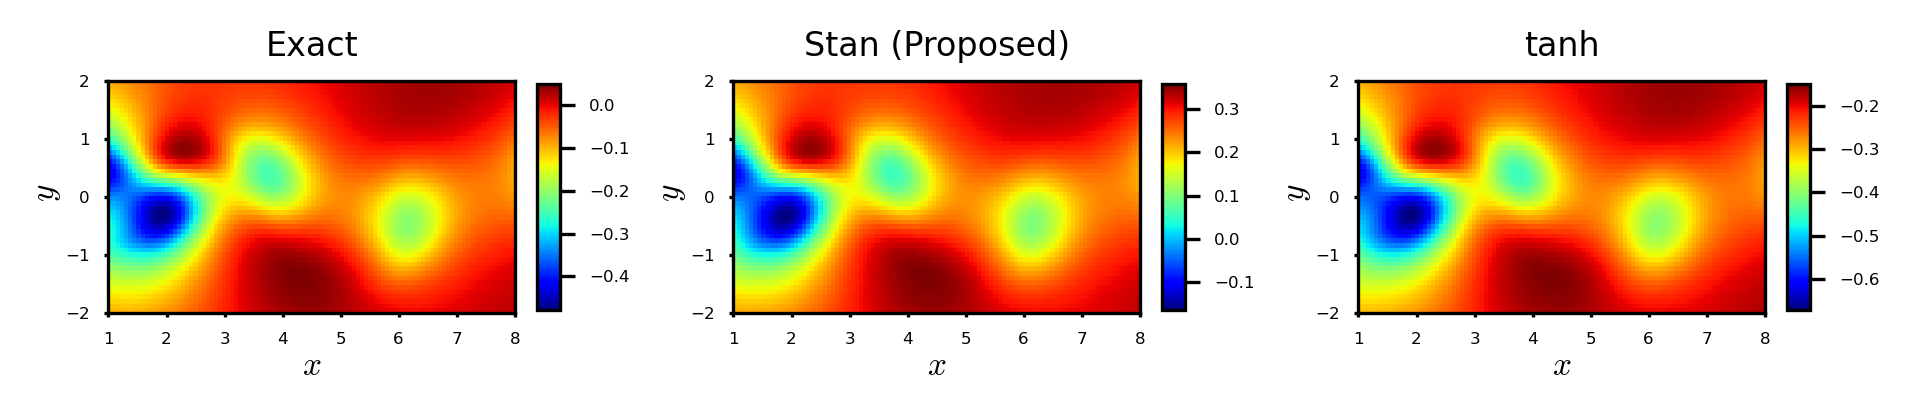

In [37]:
fig, axs = plt.subplots(1,3)
cmap = plt.cm.jet

rep_num = 2

pi = np.pi

loss_thresh = 0.1

fig.dpi=300
fig.tight_layout()

layers = np.array([3,50,50,50,50,2])#9 hidden layers

algo_names = ['stan','tanh','atanh','swish','rowdy']
prob_name = "3D_NS_"
# plt_titles = ['Stan (Proposed)','tanh']

PINNs = [Sequentialmodel_stan(layers,0.25),Sequentialmodel_tanh(layers,0.25)] 
extent = [1,8,-2,2]

img = axs[0].imshow(p_true_test.reshape(50,100),cmap = cmap,extent=extent)
cbar = fig.colorbar(img, ax=axs[0], aspect = 10, panchor = (0,0),fraction=0.05)
cbar.ax.tick_params(labelsize=4,labelbottom = True,labeltop = False, bottom =True, top = False)

rep_num = 0

for i in range(2):
    PINNs[i].load_state_dict(torch.load(prob_name + algo_names[i] + '_'+str(rep_num)+'.pt',map_location=device))

    _,_,p_pred = PINNs[i].test()
    
    img = axs[i+1].imshow(p_pred.reshape(50,100),cmap = cmap,extent=extent) 
    axs[i+1].set_xlabel('$x$', fontsize=8, math_fontfamily='cm', labelpad=0.5)
    axs[i+1].set_ylabel(' $y$',fontsize=8, math_fontfamily='cm', labelpad=0.5)
    axs[i+1].tick_params(axis='x', labelsize=4,length = 1)
    axs[i+1].tick_params(axis='y', labelsize=4,length = 1)
    
    cbar = fig.colorbar(img, ax=axs[i+1], aspect = 10, panchor = (0,0),fraction=0.05)
    cbar.ax.tick_params(labelsize=4,labelbottom = True,labeltop = False, bottom =True, top = False)
   
    
# cbar = fig.colorbar(img, ax=axs,location = 'bottom',orientation = 'horizontal', aspect = 100,panchor = (0,-1.5))
# cbar.ax.tick_params(labelsize=4,labelbottom = True,labeltop = False, bottom =True, top = False) 
# axs[1,1].set_xlabel('$x$', fontsize=8, math_fontfamily='cm', labelpad=0.5)
# axs[1,1].set_ylabel(' $y$',fontsize=8, math_fontfamily='cm', labelpad=0.5)
# axs[1,1].tick_params(axis='x', labelsize=4,length = 1)
# axs[1,1].tick_params(axis='y', labelsize=4,length = 1)


# cbar = fig.colorbar(img1, ax=axs,location = 'bottom',orientation = 'horizontal', aspect = 100, panchor = (0,-4.75))
# cbar.ax.tick_params(labelsize=4,labelbottom = True,labeltop = False, bottom =True, top = False) 
axs[0].set_xlabel('$x$', fontsize=8, math_fontfamily='cm', labelpad=0.5)
axs[0].set_ylabel(' $y$',fontsize=8, math_fontfamily='cm', labelpad=0.5)
axs[0].tick_params(axis='x', labelsize=4,length = 1)
axs[0].tick_params(axis='y', labelsize=4,length = 1)

fig.subplots_adjust(top = 1.0,bottom = 0.6)

plt_titles = ['Exact','Stan (Proposed)','tanh']
for i in range(3):
    axs[i].set_title(plt_titles[i],fontsize=8, math_fontfamily='cm')
    
# plt.savefig('KG_'+level +'_pred_error.png', format='png',pad_inches=0, bbox_inches='tight',transparent=True)    
plt.savefig('Inv_NS_pred.pdf', format='pdf',pad_inches=0, bbox_inches='tight',transparent=True)